In [1]:
from periodicLatticeSolver import PeriodicLatticeSolver
from minimizer import Minimizer
import numpy as np
from FloorPlanClass import FloorPlan
from plotter import Plotter
PLS = PeriodicLatticeSolver(200, .02, axis='both')
PLS.add_Injector()

L1 = PLS.Variable('L1', varMin=.01, varMax=.5)
L2= PLS.Variable('L2', varMin=.01, varMax=.5)
L3 =PLS.Variable('L3', varMin=.01, varMax=.5)
L4= PLS.Variable('L4', varMin=.01, varMax=.5)

Bp1 = .45
Bp2 = .45
Bp3 = .45
Bp4 = .45

rp1 = PLS.Variable('rp1', varMin=.01, varMax=.03)
rp2 = PLS.Variable('rp2', varMin=.01, varMax=.03)
rp3 = PLS.Variable('rp3', varMin=.01, varMax=.03)
rp4 = PLS.Variable('rp4', varMin=.01, varMax=.03)

r0=PLS.Variable('r0',varMin=1,varMax=1.3)
TL1=PLS.Variable('TL1',varMin=.5,varMax=1.5)
TL2=PLS.Variable('TL2',varMin=.5,varMax=1.5)


PLS.set_Track_Length(TL1=TL1,TL2=TL2)
PLS.begin_Lattice()

PLS.add_Bend(np.pi, r0, .45)
#PLS.add_Drift(L=.03)
PLS.add_Lens(L4, Bp4, rp4)
PLS.add_Drift()
PLS.add_Combiner()
PLS.add_Drift()
PLS.add_Lens(L1, Bp1,rp1)
#PLS.add_Drift(L=.03)
PLS.add_Bend(np.pi, r0, .45)
#PLS.add_Drift(L=.03)
PLS.add_Lens(L2, Bp2, rp2)
PLS.add_Drift()
PLS.add_Lens(L3, Bp3, rp3)
#PLS.add_Drift(L=.03)
PLS.end_Lattice()

Lattice model completed


100%|██████████| 250/250 [08:04<00:00,  1.94s/it]


minCost for each thread:  [4.         1.74797858 1.6068024  1.9        1.84127069 1.74778118
 1.9        1.81885412 1.9        1.79394149 1.9        1.79393215]


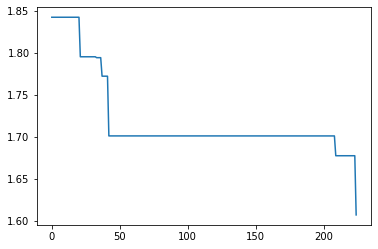

[0.22961927 0.5        0.26170249 0.25039602 0.02420218 0.028053
 0.02006238 0.01885641 1.27980752 0.61902117 1.12162673 0.09785844
 0.06607753 0.03389865] 1.6068023982446973
70 66
percent particles surviving (x,y): 12.5, 17.5
[0.22961927 0.5        0.26170249 0.25039602 0.02420218 0.028053
 0.02006238 0.01885641 1.27980752 0.61902117 1.12162673 0.09785844
 0.06607753 0.03389865] 1.6068023982446973
done
Total time 8 minutes and 5 seconds


In [11]:
minimizer=Minimizer(PLS)
minimizer.find_Global_Min(mut=.75, crossPop=.7, iterations=250, popPerDim=20,strategy='best/1')

[0.2296 0.5    0.2617 0.2504 0.0242 0.0281 0.0201 0.0189 1.2798 0.619
 1.1216]


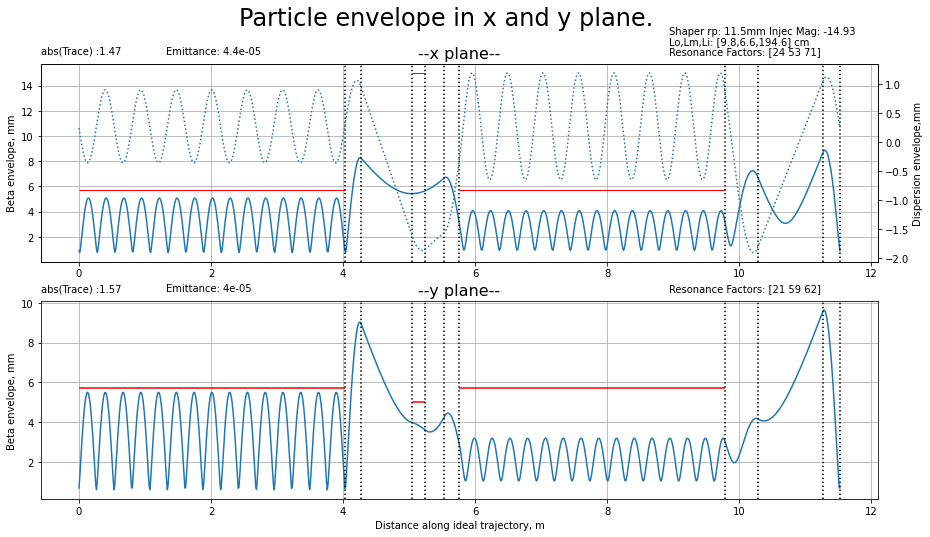

In [12]:
plotter=Plotter(PLS)
plotter.plot(sol=minimizer.sol)

In [ ]:
floorPlan=FloorPlan(PLS)
floorPlan.show_Floor_Plan(sol=minimizer.sol)
floorPlan.calculate_Cost()